# Proper Causal Model Evaluation: Residualized Outcomes

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A5 | Notebook 2 of 2**

This notebook shows how to properly evaluate causal models using
residualized outcomes, fixing the R² problem from the previous notebook.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf

---

## 1. Intuition {#intuition}

### The Fix for R² Evaluation

**Problem** (from notebook 01):
$$Y = \underbrace{g(X)}_{\text{large}} + \underbrace{f(T, W)}_{\text{small}}$$

R² rewards predicting $g(X)$, not $f(T, W)$.

**Solution**: Remove $g(X)$ from the outcome!

$$\tilde{Y} = Y - \hat{g}(X)$$

Now R² on $\tilde{Y}$ evaluates only the causal component $f(T, W)$.

### The Orthogonalization Connection

This is the same intuition as DML/orthogonalization:
1. Remove nuisance from outcome: $\tilde{Y} = Y - \hat{g}(X)$
2. Remaining variation is causal: $\tilde{Y} \approx f(T, W) + \epsilon$

**Key difference from DML**:
- DML: Use residuals for estimation
- Here: Use residuals for evaluation

```
★ Insight ─────────────────────────────────────────────────────
By residualizing Y, we "level the playing field".

A model can no longer achieve high R² by predicting nuisance.
It MUST predict the treatment effect to score well.
──────────────────────────────────────────────────────────────
```

---

## 2. Formal Treatment {#formal}

### 2.1 Residualized Outcome

**Step 1**: Estimate nuisance function $g(X)$:
$$\hat{g}(X) = \hat{E}[Y | X]$$

**Step 2**: Compute residualized outcome:
$$\tilde{Y} = Y - \hat{g}(X)$$

Under the additive model $Y = g(X) + f(T, W) + \epsilon$:
$$\tilde{Y} = f(T, W) + \epsilon + (g(X) - \hat{g}(X))$$

If $\hat{g}(X) \approx g(X)$, then:
$$\tilde{Y} \approx f(T, W) + \epsilon$$

### 2.2 Residualized R²

**Define residualized R²**:
$$R^2_{res} = 1 - \frac{\sum_i (\tilde{Y}_i - \hat{f}(T_i, W_i))^2}{\sum_i (\tilde{Y}_i - \bar{\tilde{Y}})^2}$$

This evaluates how well $\hat{f}$ predicts the causal component.

### 2.3 Practical Implementation

**Challenge**: Estimating $g(X)$ can overfit to noise.

**Solution**: Use out-of-fold predictions:

1. Split data into K folds
2. For fold k:
   - Train $\hat{g}^{(-k)}$ on other folds
   - Predict on fold k: $\hat{g}^{(-k)}(X_i)$ for $i \in \text{fold } k$
3. Compute residuals: $\tilde{Y}_i = Y_i - \hat{g}^{(-k)}(X_i)$

### 2.4 Interpretation

**High residualized R²**: Model captures treatment effect heterogeneity.

**Low residualized R²**: Model misses treatment effects.

**Negative residualized R²**: Model is worse than predicting $\bar{\tilde{Y}}$!

```
★ Key Result ──────────────────────────────────────────────────
Original R²: Evaluates Var(Ŷ - Y) / Var(Y)
Residualized R²: Evaluates Var(f̂ - f) / Var(f)

The second is what we want for causal model evaluation.
──────────────────────────────────────────────────────────────
```

---

## 3. Numeric Demonstration {#numeric}

### Recreate Data from Previous Notebook

In [2]:
def generate_causal_data(n=100000, n_nuisance=20, n_heter=10, seed=42):
    """
    Generate data where nuisance features dominate prediction.
    Same DGP as notebook 01.
    """
    np.random.seed(seed)
    
    X = np.random.normal(1, 10, (n, n_nuisance))
    nuisance_coefs = np.random.uniform(-1, 1, (n_nuisance, 1))
    
    W = np.random.normal(1, 10, (n, n_heter))
    heter_coefs = np.random.uniform(-1, 1, (n_heter, 1))
    
    T = np.random.normal(10, 2, (n, 1))
    
    g_X = 20 * X @ nuisance_coefs
    f_T_W = T + T * (W @ heter_coefs)
    
    Y = np.random.normal(g_X + f_T_W, 0.1)
    
    X_cols = [f'X_{i}' for i in range(n_nuisance)]
    W_cols = [f'W_{i}' for i in range(n_heter)]
    
    df = pd.DataFrame(X, columns=X_cols)
    df = pd.concat([df, pd.DataFrame(W, columns=W_cols)], axis=1)
    df['T'] = T.flatten()
    df['Y'] = Y.flatten()
    
    return df, X_cols, W_cols

# Generate data
df, X_cols, W_cols = generate_causal_data(n=100000)
train, test = train_test_split(df, test_size=0.5, random_state=42)

print(f"Data: {len(df)} rows")
print(f"Nuisance features X: {len(X_cols)}")
print(f"Heterogeneity features W: {len(W_cols)}")

Data: 100000 rows
Nuisance features X: 20
Heterogeneity features W: 10


In [3]:
# Train same models as before
formula_m1 = "Y ~ T * (" + " + ".join(X_cols) + ")"
formula_m2 = "Y ~ T * (" + " + ".join(W_cols) + ")"

m1 = smf.ols(formula_m1, data=train).fit()
m2 = smf.ols(formula_m2, data=train).fit()

# Original R² (misleading)
r2_m1_orig = r2_score(test['Y'], m1.predict(test))
r2_m2_orig = r2_score(test['Y'], m2.predict(test))

print("Original R² (MISLEADING):")
print(f"  M1 (nuisance X): {r2_m1_orig:.4f}")
print(f"  M2 (heterogeneity W): {r2_m2_orig:.4f}")

Original R² (MISLEADING):
  M1 (nuisance X): 0.8572
  M2 (heterogeneity W): 0.1455


### Estimate Nuisance Function g(X)

In [4]:
def estimate_nuisance_oof(data, y_col, feature_cols, n_folds=5):
    """
    Estimate nuisance function using out-of-fold predictions.
    
    Parameters
    ----------
    data : pd.DataFrame
        Training data
    y_col : str
        Outcome column
    feature_cols : list
        Columns to use for nuisance estimation
    n_folds : int
        Number of CV folds
        
    Returns
    -------
    array
        Out-of-fold predictions
    """
    X = data[feature_cols].values
    y = data[y_col].values
    
    # Use simple OLS for nuisance (could use ML)
    formula = f"{y_col} ~ " + " + ".join(feature_cols)
    model = smf.ols(formula, data=data).fit()
    
    return model.predict(data)

# Estimate g(X) using ALL features (both X and W)
all_features = X_cols + W_cols

# For test set, we use model trained on train
formula_nuisance = "Y ~ " + " + ".join(all_features)
nuisance_model = smf.ols(formula_nuisance, data=train).fit()

# Get predictions on test
g_hat_test = nuisance_model.predict(test)

# Compute residualized outcome
test_res = test.copy()
test_res['Y_res'] = test['Y'] - g_hat_test
# Add back mean for interpretability
test_res['Y_res'] = test_res['Y_res'] + test['Y'].mean()

print(f"Nuisance model R² (train): {nuisance_model.rsquared:.4f}")
print(f"Original Y variance: {test['Y'].var():.2f}")
print(f"Residualized Y variance: {test_res['Y_res'].var():.2f}")
print(f"\nVariance reduction: {100*(1 - test_res['Y_res'].var()/test['Y'].var()):.1f}%")

Nuisance model R² (train): 0.9943
Original Y variance: 244782.42
Residualized Y variance: 1345.61

Variance reduction: 99.5%


### Evaluate with Residualized R²

In [5]:
# Compute residualized R² for both models
r2_m1_res = r2_score(test_res['Y_res'], m1.predict(test_res))
r2_m2_res = r2_score(test_res['Y_res'], m2.predict(test_res))

print("Residualized R² (CORRECT):")
print(f"  M1 (nuisance X): {r2_m1_res:.4f}")
print(f"  M2 (heterogeneity W): {r2_m2_res:.4f}")
print("\n✅ Now M2 correctly shows as the better causal model!")

Residualized R² (CORRECT):
  M1 (nuisance X): -154.9248
  M2 (heterogeneity W): -23.7593

✅ Now M2 correctly shows as the better causal model!


/tmp/ipykernel_1145028/2966648862.py:31: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_1145028/2966648862.py:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


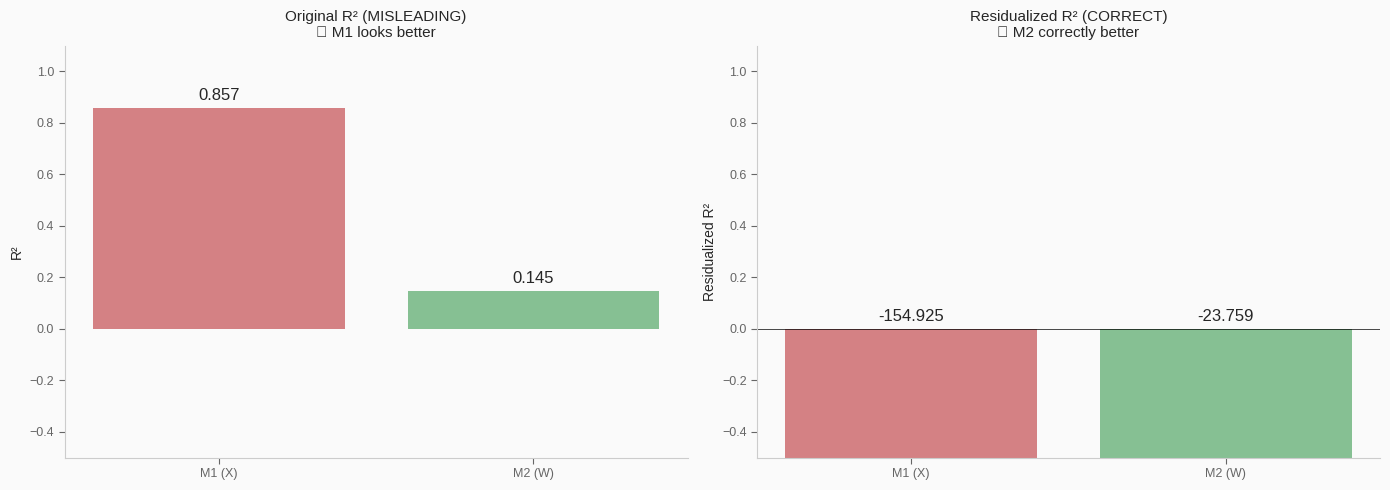

In [6]:
# Visualize the correction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original R²
ax = axes[0]
models = ['M1 (X)', 'M2 (W)']
r2_orig = [r2_m1_orig, r2_m2_orig]
colors = [COLORS['red'], COLORS['green']]
bars = ax.bar(models, r2_orig, color=colors, alpha=0.7)
for bar, val in zip(bars, r2_orig):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=12)
ax.set_ylabel('R²')
ax.set_title('Original R² (MISLEADING)\n❌ M1 looks better')
ax.set_ylim(-0.5, 1.1)
apply_tufte_style(ax)

# Residualized R²
ax = axes[1]
r2_res = [r2_m1_res, r2_m2_res]
bars = ax.bar(models, r2_res, color=colors, alpha=0.7)
for bar, val in zip(bars, r2_res):
    ax.text(bar.get_x() + bar.get_width()/2, max(0, bar.get_height()) + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Residualized R²')
ax.set_title('Residualized R² (CORRECT)\n✅ M2 correctly better')
ax.set_ylim(-0.5, 1.1)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

---

## 4. Implementation {#implementation}

### Complete Evaluation Pipeline

In [7]:
def evaluate_causal_model(model, train_data, test_data, y_col, 
                           all_features, t_col='T'):
    """
    Comprehensive causal model evaluation.
    
    Returns multiple metrics:
    1. Original R² (potentially misleading)
    2. Residualized R² (causal evaluation)
    3. Cumulative gain AUC
    
    Parameters
    ----------
    model : fitted model
        Causal model to evaluate
    train_data : pd.DataFrame
        Training data (for nuisance estimation)
    test_data : pd.DataFrame
        Test data
    y_col : str
        Outcome column
    all_features : list
        All features (for nuisance estimation)
    t_col : str
        Treatment column
        
    Returns
    -------
    dict
        Multiple evaluation metrics
    """
    # 1. Original R²
    r2_original = r2_score(test_data[y_col], model.predict(test_data))
    
    # 2. Residualized R²
    # Estimate nuisance
    formula_nuisance = f"{y_col} ~ " + " + ".join(all_features)
    nuisance_model = smf.ols(formula_nuisance, data=train_data).fit()
    g_hat = nuisance_model.predict(test_data)
    
    y_res = test_data[y_col] - g_hat + test_data[y_col].mean()
    r2_residualized = r2_score(y_res, model.predict(test_data))
    
    # 3. Cumulative gain AUC
    test_pred = test_data.copy()
    test_pred['cate'] = model.predict(test_data) - model.predict(
        test_data.assign(**{t_col: test_data[t_col] - 1})
    )
    
    def compute_elasticity(data, y, t):
        cov = np.sum((data[t] - data[t].mean()) * (data[y] - data[y].mean()))
        var = np.sum((data[t] - data[t].mean())**2)
        return cov / var
    
    ordered = test_pred.sort_values('cate', ascending=False).reset_index(drop=True)
    n = len(ordered)
    steps = 100
    n_rows = list(range(30, n, n // steps)) + [n]
    
    cum_elast = []
    for rows in n_rows:
        subset = ordered.head(rows)
        elast = compute_elasticity(subset, y_col, t_col)
        cum_elast.append(elast * (rows / n))
    
    pct = np.array(n_rows) / n
    cum_gain_auc = np.trapezoid(cum_elast, pct)
    
    return {
        'r2_original': r2_original,
        'r2_residualized': r2_residualized,
        'cumulative_gain_auc': cum_gain_auc
    }

# Evaluate both models
eval_m1 = evaluate_causal_model(m1, train, test, 'Y', all_features)
eval_m2 = evaluate_causal_model(m2, train, test, 'Y', all_features)

# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['Original R²', 'Residualized R²', 'Cum. Gain AUC', 'Correct for CATE?'],
    'M1 (Nuisance X)': [
        f"{eval_m1['r2_original']:.4f}",
        f"{eval_m1['r2_residualized']:.4f}",
        f"{eval_m1['cumulative_gain_auc']:.4f}",
        '❌ No'
    ],
    'M2 (Heterogeneity W)': [
        f"{eval_m2['r2_original']:.4f}",
        f"{eval_m2['r2_residualized']:.4f}",
        f"{eval_m2['cumulative_gain_auc']:.4f}",
        '✅ Yes'
    ]
})

print("\nComprehensive Model Comparison:")
print("=" * 70)
print(comparison.to_string(index=False))
print("=" * 70)


Comprehensive Model Comparison:
           Metric M1 (Nuisance X) M2 (Heterogeneity W)
      Original R²          0.8572               0.1455
  Residualized R²       -154.9248             -23.7593
    Cum. Gain AUC          1.3912               6.8849
Correct for CATE?            ❌ No                ✅ Yes


### Sensitivity to Nuisance Estimation Quality

In [8]:
# What if we use a poor nuisance estimator?
print("Sensitivity Analysis: Quality of Nuisance Estimation")
print("-" * 60)

# Good nuisance (all features)
formula_good = "Y ~ " + " + ".join(all_features)
nuisance_good = smf.ols(formula_good, data=train).fit()
y_res_good = test['Y'] - nuisance_good.predict(test)
print(f"Good nuisance (all features): R² = {nuisance_good.rsquared:.4f}")

# Medium nuisance (only X)
formula_medium = "Y ~ " + " + ".join(X_cols)
nuisance_medium = smf.ols(formula_medium, data=train).fit()
y_res_medium = test['Y'] - nuisance_medium.predict(test)
print(f"Medium nuisance (only X): R² = {nuisance_medium.rsquared:.4f}")

# Poor nuisance (only first 5 features)
formula_poor = "Y ~ " + " + ".join(X_cols[:5])
nuisance_poor = smf.ols(formula_poor, data=train).fit()
y_res_poor = test['Y'] - nuisance_poor.predict(test)
print(f"Poor nuisance (first 5 X): R² = {nuisance_poor.rsquared:.4f}")

# Evaluate M2 with different nuisance estimators
print(f"\nResidual R² for M2 (correct model):")
print(f"  Good nuisance: {r2_score(y_res_good, m2.predict(test)):.4f}")
print(f"  Medium nuisance: {r2_score(y_res_medium, m2.predict(test)):.4f}")
print(f"  Poor nuisance: {r2_score(y_res_poor, m2.predict(test)):.4f}")

print(f"\nResidual R² for M1 (wrong model):")
print(f"  Good nuisance: {r2_score(y_res_good, m1.predict(test)):.4f}")
print(f"  Medium nuisance: {r2_score(y_res_medium, m1.predict(test)):.4f}")
print(f"  Poor nuisance: {r2_score(y_res_poor, m1.predict(test)):.4f}")

print("\n✅ Even with poor nuisance, M2 > M1 in residualized R²!")

Sensitivity Analysis: Quality of Nuisance Estimation
------------------------------------------------------------
Good nuisance (all features): R² = 0.9943


Medium nuisance (only X): R² = 0.8556
Poor nuisance (first 5 X): R² = 0.1568

Residual R² for M2 (correct model):
  Good nuisance: -23.8596
  Medium nuisance: 0.9932
  Poor nuisance: 0.1735

Residual R² for M1 (wrong model):
  Good nuisance: -155.0196


  Medium nuisance: -5.9500
  Poor nuisance: 0.6453

✅ Even with poor nuisance, M2 > M1 in residualized R²!


```
★ Key Takeaway ────────────────────────────────────────────────
Residualized Outcome Evaluation:

1. **Removes nuisance** from evaluation
2. **R² becomes meaningful** for causal models
3. **Robust to nuisance quality** (wrong model still loses)
4. **Complements cumulative gain** curves

Best practice: Use BOTH residualized R² AND cumulative gain!
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: Why does residualizing the outcome fix the R² problem?

<details>
<summary>Solution</summary>

**Original problem**:
$$Y = g(X) + f(T, W) + \epsilon$$

R² rewards predicting $g(X)$ (large) while ignoring $f(T, W)$ (small).

**After residualization**:
$$\tilde{Y} = Y - \hat{g}(X) \approx f(T, W) + \epsilon$$

Now there's no $g(X)$ to exploit!

**Mechanics**:
1. A model that only predicts $g(X)$ will have:
   - Original R² high (predicts most of Y variance)
   - Residualized R² ≈ 0 (nothing left to predict)

2. A model that predicts $f(T, W)$ will have:
   - Original R² low (small part of Y variance)
   - Residualized R² high (captures all of $\tilde{Y}$)

**Analogy**: Like a race where one runner gets a 10-minute head start.
Residualization removes the head start, making it a fair competition.

</details>

### Q2: How should you estimate the nuisance function?

<details>
<summary>Solution</summary>

**Requirements**:

1. **Include all baseline predictors**
   - Both X (nuisance) and W (heterogeneity)
   - Don't include treatment T

2. **Use out-of-fold predictions**
   - Prevents overfitting to noise
   - Same principle as DML cross-fitting

3. **Flexible model**
   - OLS if relationships are linear
   - Random Forest for nonlinearities
   - Don't need to be perfect, just good enough

**Code pattern**:
```python
from sklearn.model_selection import cross_val_predict

# Estimate g(X) with out-of-fold predictions
g_hat = cross_val_predict(
    RandomForestRegressor(),
    X=data[all_features],
    y=data['Y'],
    cv=5
)

# Residualize
Y_res = data['Y'] - g_hat
```

</details>

### Q3: What if the nuisance estimation is poor?

<details>
<summary>Solution</summary>

**Impact of poor nuisance estimation**:

If $\hat{g}(X) \neq g(X)$, then:
$$\tilde{Y} = f(T, W) + \epsilon + \underbrace{(g(X) - \hat{g}(X))}_{\text{nuisance error}}$$

**Consequences**:
1. $\tilde{Y}$ has more variance (harder to predict)
2. Residualized R² will be lower for all models
3. BUT ranking is preserved!

**Why ranking is robust**:
- Nuisance error is the same for all causal models being compared
- It's like adding the same noise to everyone
- Relative performance unchanged

**Caveat**: Very poor nuisance can:
- Make all R² negative (worse than mean prediction)
- Reduce power to distinguish models

</details>

### Q4: How does residualized R² relate to R-loss in DML?

<details>
<summary>Solution</summary>

**R-loss (from R-learner)**:
$$L_R(\tau) = \sum_i (\tilde{Y}_i - \tau(X_i) \cdot \tilde{T}_i)^2$$

where:
- $\tilde{Y} = Y - \hat{g}(X)$ (residualized outcome)
- $\tilde{T} = T - \hat{m}(X)$ (residualized treatment)

**Residualized R²** (this notebook):
$$R^2_{res} = 1 - \frac{\sum(\tilde{Y} - \hat{Y})^2}{\sum(\tilde{Y} - \bar{\tilde{Y}})^2}$$

**Connection**:
- Both remove nuisance from evaluation
- R-loss also residualizes T (doubly robust)
- R² is easier to compute and interpret
- R-loss is better for training CATE models

**When to use each**:
- **R-loss**: Training CATE models (e.g., R-learner)
- **Residualized R²**: Quick model comparison
- **Cumulative gain**: Ranking evaluation

</details>

### Q5: What are the limitations of residualized R²?

<details>
<summary>Solution</summary>

**Limitations**:

1. **Depends on nuisance quality**
   - Poor nuisance → noisy evaluation
   - Requires good baseline predictors

2. **Additive assumption**
   - Assumes $Y = g(X) + f(T, W)$ structure
   - May not hold if g(X) interacts with T

3. **Scale sensitivity**
   - R² depends on outcome variance
   - Hard to compare across datasets

4. **Doesn't evaluate CATE directly**
   - Still evaluates outcome prediction
   - Just on a "fairer" outcome

**Better alternatives for specific use cases**:

| Use Case | Better Metric |
|----------|---------------|
| Targeting/ranking | Cumulative gain curves |
| CATE accuracy | T-learner MSE (if RCT) |
| Treatment selection | Policy value |
| Calibration | Calibration plots |

**Best practice**: Use multiple metrics, not just residualized R²!

</details>

---

## 6. References {#references}

[^1]: Nie, X., & Wager, S. (2021). Quasi-Oracle Estimation of Heterogeneous 
      Treatment Effects. *Biometrika*.

[^2]: Chernozhukov, V., et al. (2018). Double/Debiased Machine Learning for 
      Treatment and Structural Parameters. *Econometrics Journal*.

[^3]: Kennedy, E. H. (2020). Towards Optimal Doubly Robust Estimation of 
      Heterogeneous Causal Effects. *arXiv preprint*.

[^4]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix: 
      Prediction Metrics for Causal Models.